In [1]:
import xarray as xr
import numpy as np
from os.path import join
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aibedo_demo_data"


In [8]:
plt.rcParams['figure.figsize'] = [25, 8]  # general matplotlib parameters

In [9]:
order5_data_fn = 'compress.isosph5.CESM2.historical.r1i1p1f1.Input.Exp8_fixed.nc'
order6_data_fn = 'compress.isosph.CESM2.historical.r1i1p1f1.Input.Exp8_fixed.nc'
order5_data_fn = xr.open_dataset(join(DATA_DIR, order5_data_fn))
order6_data_fn = xr.open_dataset(join(DATA_DIR, order6_data_fn))

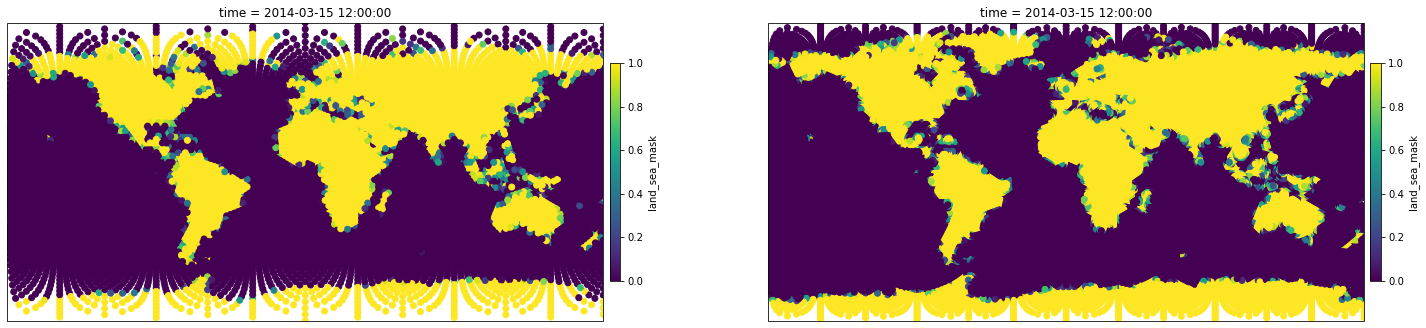

In [10]:
scatter_kwargs = dict(
    x='lon', y='lat', 
    subplot_kws={'projection':  ccrs.PlateCarree()},
    cbar_kwargs={
        'shrink': 0.5,  # make cbar smaller/larger
        'pad': 0.01,  # padding between right-ost subplot and cbar
        'fraction': 0.05}
)
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})
order5_data_fn.isel(time=-10).plot.scatter(**scatter_kwargs, hue='lsMask', ax=axs[0])
order6_data_fn.isel(time=-10).plot.scatter(**scatter_kwargs, hue='lsMask', ax=axs[1])

In [11]:
def add_clusters(ds, n_clusters = 2):
    ncells = ds.sizes['ncells']
    # assert ncells % n_clusters == 0, f'{ncells} vs {n_clusters}'
    rpt = int(ncells / n_clusters) + 1
    ds['random_clusters1'] = ('ncells', np.arange(n_clusters).repeat(rpt)[:ncells])

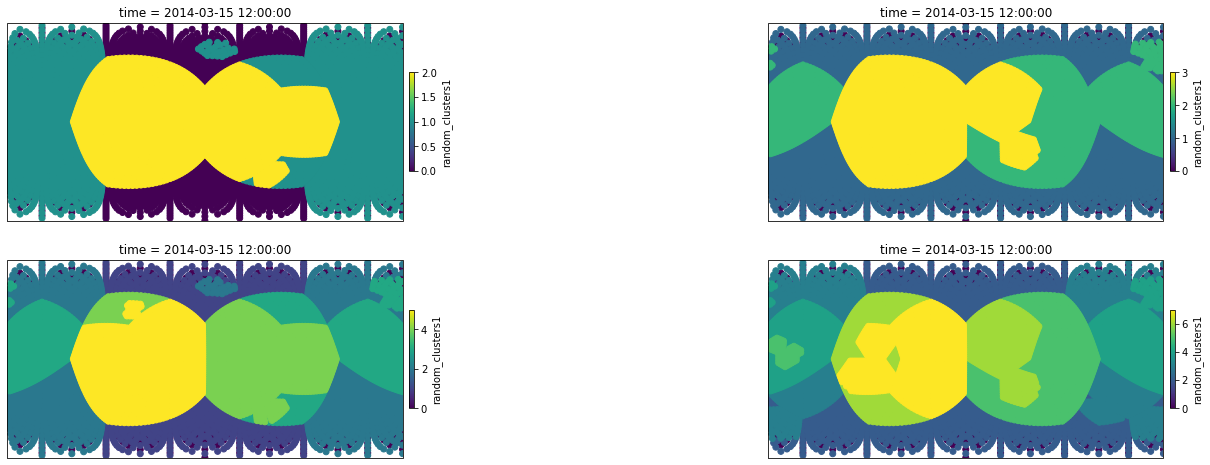

In [12]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flat
for i, nc in enumerate([3, 4, 6, 8]):
    add_clusters(order5_data_fn, n_clusters=nc)
    order5_data_fn.isel(time=-10).plot.scatter(**scatter_kwargs, hue='random_clusters1', ax=axs[i])

#### Regular partitioning in the lat lon space

In [13]:
import pandas as pd

In [14]:
# Partition parameters
x_part_num = 10 #long partition counts
x_part_boundaries = np.linspace(-180.0, 180.0, x_part_num + 1)

y_part_num = 10 #lat partition counts
y_part_boundaries = np.linspace(-90.0, 90.0, y_part_num + 1)

print("lon partition boundaries = ", y_part_boundaries)
print("lat partition boundaries = ", y_part_boundaries)

lon partition boundaries =  [-90. -72. -54. -36. -18.   0.  18.  36.  54.  72.  90.]
lat partition boundaries =  [-90. -72. -54. -36. -18.   0.  18.  36.  54.  72.  90.]


In [15]:
#extract lat lon datafran from the dataset
def get_lat_lon_df(ds):
    num_points = ds.lon.data.shape[0]
    point_id_array = np.zeros((num_points,), dtype=np.int32)
    new_array = np.vstack((ds.lat.data, ds.lon.data, point_id_array))
    column_name = ['lat', 'lon', 'pid']
    # creating the dataframe
    new_df = pd.DataFrame(data = new_array.T, columns = column_name)
    
    return new_df


In [16]:
def create_reg_partition(ds):
    #create a new location dataframe with partition ids initialized to zero
    local_df = get_lat_lon_df(ds)

    #first split along X-direction
    for x in range(x_part_num):
        local_df.loc[(local_df['lon'] >= x_part_boundaries[x]) & (local_df['lon'] <= x_part_boundaries[x+1]) , 'pid'] = x
        
    plt.figure(figsize=(15,8))
    plt.scatter(x=local_df['lon'], y=local_df['lat'], c=local_df['pid'], s=20, cmap=plt.get_cmap('prism'))
    plt.title("Intermediate Results: Longitude Partition")
    plt.show()

    pd.options.mode.chained_assignment = None  # default='warn'
    def create_Y_dir_reg_partitions(df, direction, part_num, part_boundaries, lon_pid=0, pid_offset=0):
        assert part_num + 1 == part_boundaries.shape[0]
        
        for i in range(part_num):
            cur_id = -1
            if direction == 'lat':
                cur_id = lon_pid + i*pid_offset
            elif direction == 'lon':
                cur_id = i
            df.loc[(df[direction] >= part_boundaries[i]) & (df[direction] <= part_boundaries[i+1]) , 'pid'] = cur_id
            
        
        return df  

    for x in range(x_part_num):
        temp_df = create_Y_dir_reg_partitions(local_df[local_df['pid']==x], 'lat', y_part_num, y_part_boundaries, lon_pid=x, pid_offset=x_part_num)
        local_df.update(temp_df)
        
    plt.figure(figsize=(15,8))
    plt.scatter(x=local_df['lon'], y=local_df['lat'], c=local_df['pid'], s=20, cmap=plt.get_cmap('flag'))
    
    plt.title("Final Results: Full Partition")
    plt.show()
    
    return local_df

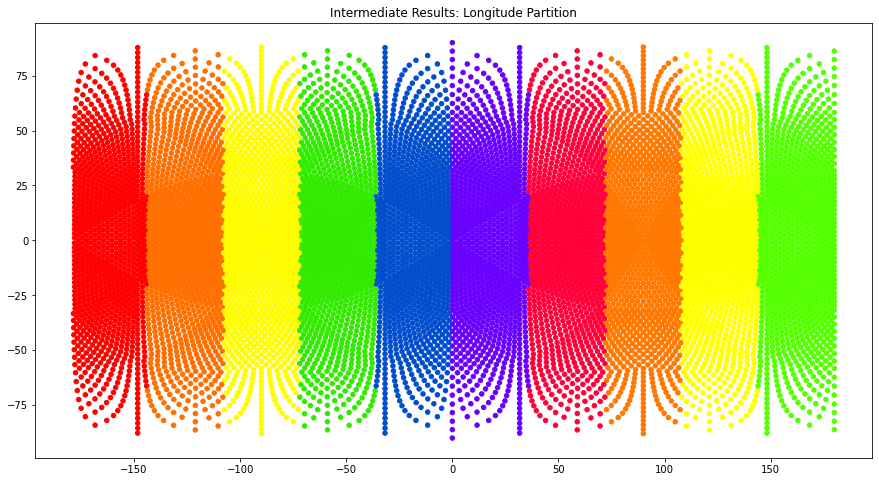

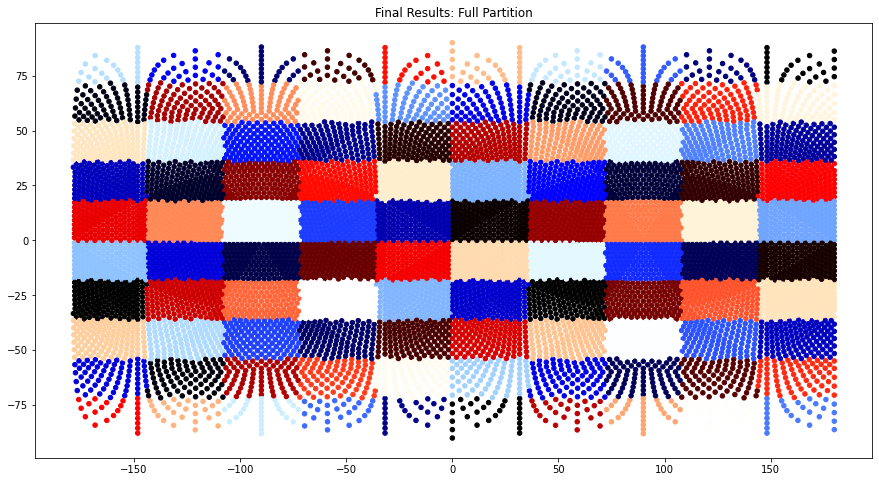

In [17]:
l5_lat_lon_df = create_reg_partition(order5_data_fn)

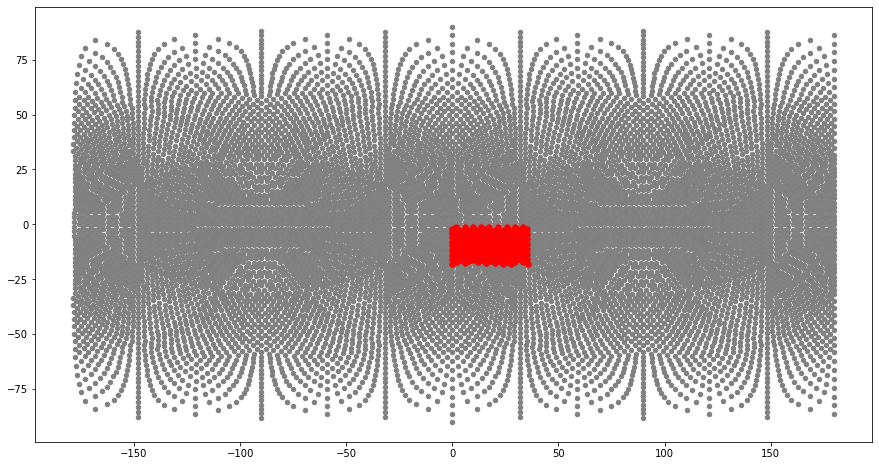

In [18]:
query_pid = 45
plt.figure(figsize=(15,8))
plt.scatter(x=l5_lat_lon_df['lon'], y=l5_lat_lon_df['lat'], c='gray', s=20, cmap=plt.get_cmap('flag'))
plt.scatter(x=l5_lat_lon_df[l5_lat_lon_df['pid'] == query_pid]['lon'], y=l5_lat_lon_df[l5_lat_lon_df['pid'] == query_pid]['lat'], c='r', s=30)

In [19]:
print("total point in all partition = ", l5_lat_lon_df['pid'].value_counts().sum())
print("max pid =", l5_lat_lon_df['pid'].max())
print("min pid =", l5_lat_lon_df['pid'].min())

total point in all partition =  10242
max pid = 99.0
min pid = 0.0


<AxesSubplot:>

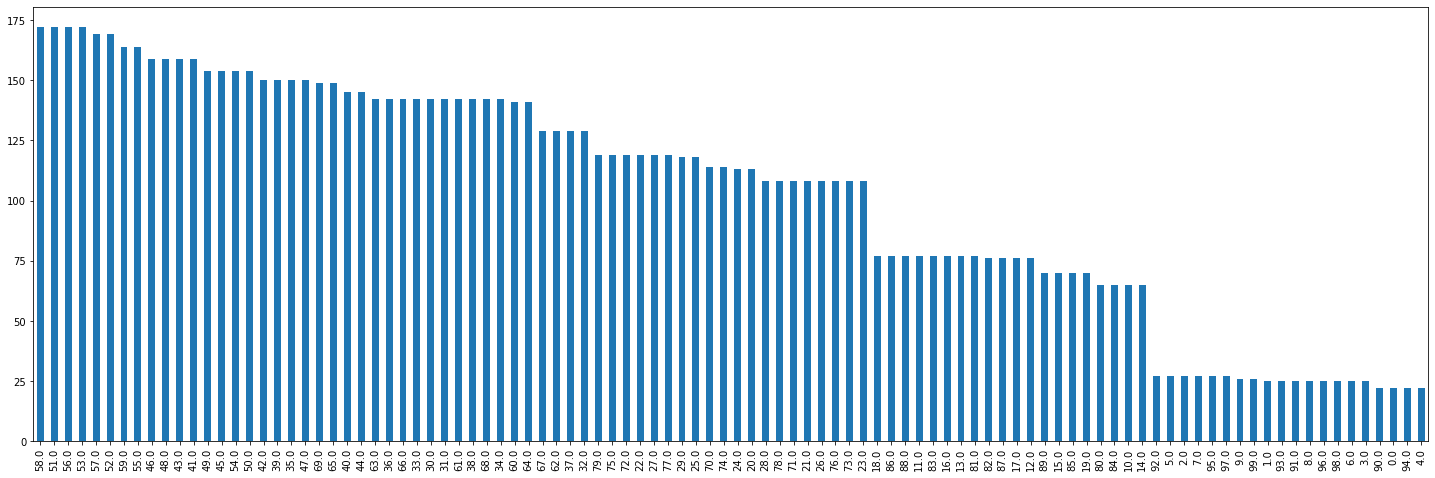

In [20]:
fig, ax = plt.subplots()
l5_lat_lon_df['pid'].value_counts().plot(ax=ax, kind='bar')

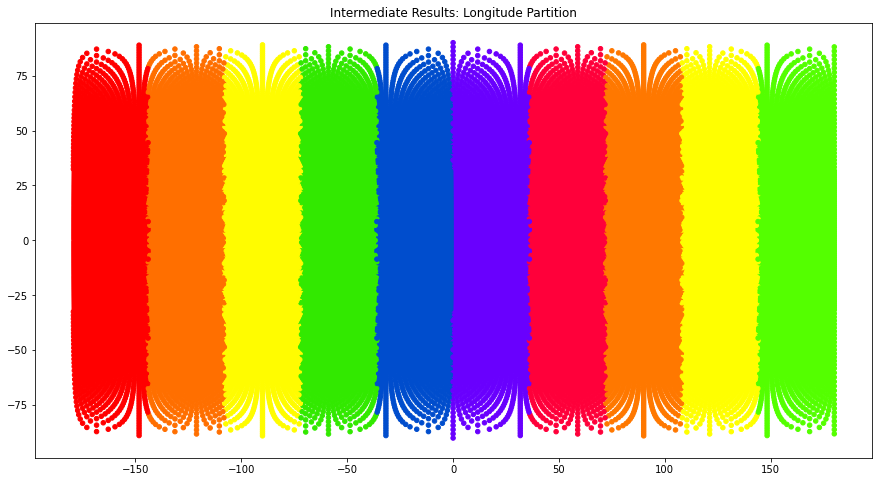

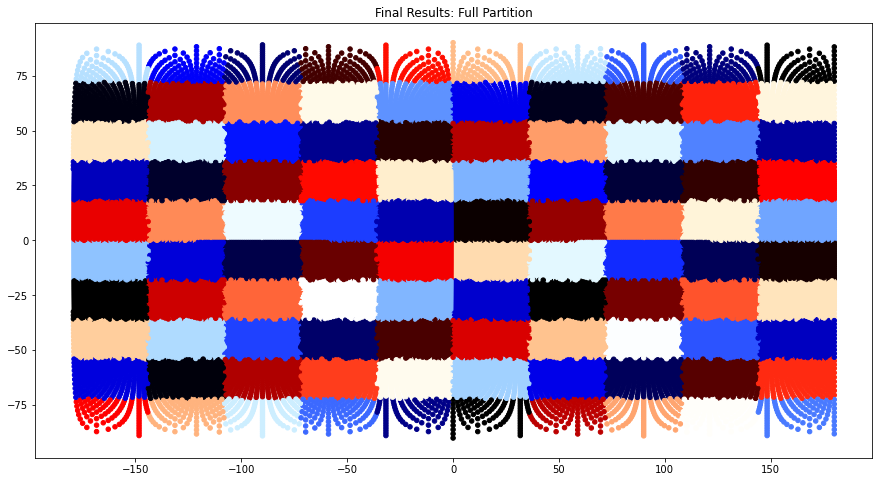

In [21]:
#for L6 data
l6_lat_lon_df = create_reg_partition(order6_data_fn)

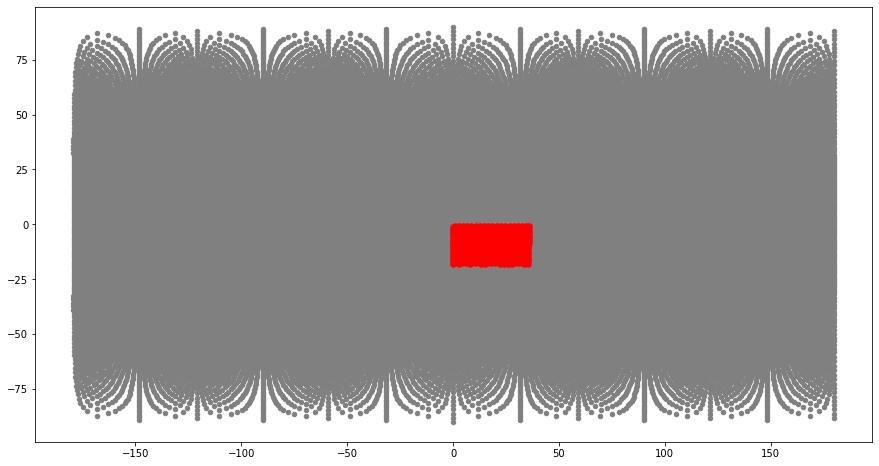

In [22]:
query_pid = 45
plt.figure(figsize=(15,8))
plt.scatter(x=l6_lat_lon_df['lon'], y=l6_lat_lon_df['lat'], c='gray', s=20, cmap=plt.get_cmap('flag'))
plt.scatter(x=l6_lat_lon_df[l6_lat_lon_df['pid'] == query_pid]['lon'], y=l6_lat_lon_df[l6_lat_lon_df['pid'] == query_pid]['lat'], c='r', s=30)

In [23]:
print("total point in all partition = ", l6_lat_lon_df['pid'].value_counts().sum())
print("max pid =", l6_lat_lon_df['pid'].max())
print("min pid =", l6_lat_lon_df['pid'].min())

total point in all partition =  40962
max pid = 99.0
min pid = 0.0


<AxesSubplot:>

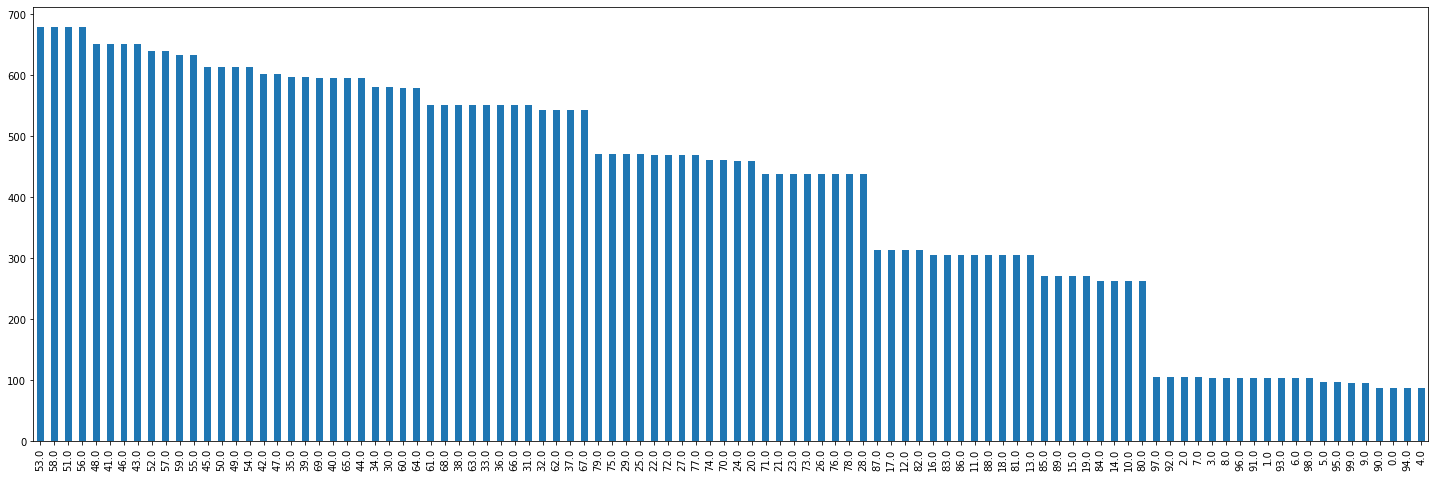

In [24]:
fig, ax = plt.subplots()
l6_lat_lon_df['pid'].value_counts().plot(ax=ax, kind='bar')